In [201]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [202]:
hsi_raw = np.load("data/hyperspectral.npy")

In [203]:
rgb_bands = [54, 32, 18]
hsi_rgb = hsi_raw[:, :, rgb_bands]
hsi_rgb = (
    hsi_rgb / hsi_rgb.max()
)

pmin, pmax = np.percentile(hsi_rgb, (1, 95), axis=(0, 1))
hsi_rgb_pimped = hsi_rgb.copy()
for i in range(pmin.size):
    hsi_rgb_pimped[:, :, i] = (hsi_rgb[:, :, i] - pmin[i]) / (pmax[i] - pmin[i])
hsi_rgb_pimped[hsi_rgb_pimped < 0] = 0
hsi_rgb_pimped[hsi_rgb_pimped > 1] = 1

Shadow detection

In [204]:
import skimage.morphology as sm

In [205]:
def detect_shadows_mask(hsi_image):
    m_intensity = np.mean(hsi_image, axis=2)
    threshold = np.percentile(m_intensity, 11)
    mask = m_intensity < threshold
    return mask

def detect_shadows(hsi_image):
    mask = detect_shadows_mask(hsi_image)
    shadow_pp = sm.opening(mask, np.ones((3, 3)))
    disk = sm.disk(25)
    # l = 20
    # disk = np.ones((l,l))
    shadow_pp = sm.closing(shadow_pp, disk)
    # shadow_pp = sm.closing(shadow_pp, sm.disk(25))
    # shadow_pp = sm.closing(shadow_pp, np.ones((20,20)))
    return shadow_pp

In [206]:
shad_mask = detect_shadows(hsi_raw)

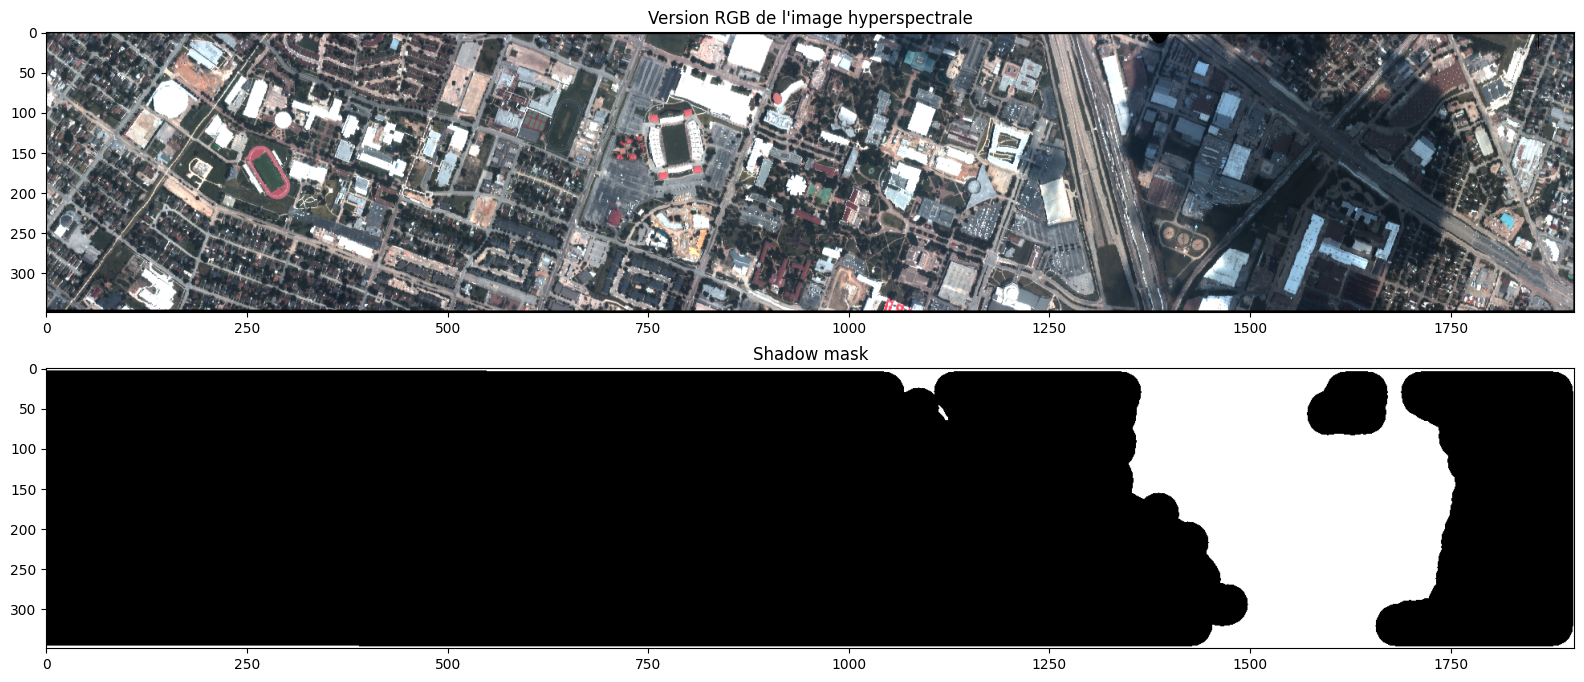

In [207]:
plt.figure(figsize=(20, 8))
plt.subplot(211)
plt.title("Version RGB de l'image hyperspectrale")
plt.imshow(hsi_rgb_pimped)
plt.subplot(212)
plt.title("Shadow mask")
plt.imshow(shad_mask, cmap="gray")
plt.show()

Add shadow detection future in hsi_image

In [208]:
hsi_raw_shadow = np.concatenate((hsi_raw, shad_mask[:, :, np.newaxis]), axis=2)
hsi_raw_shadow.shape

(349, 1905, 145)

In [209]:
lidar = np.load("data/lidar.npy")
hsi_raw_shadow = np.concatenate((hsi_raw_shadow, lidar[:, :, np.newaxis]), axis=2)
hsi_raw_shadow.shape

(349, 1905, 146)

Building classifier

In [210]:
from utils import data_get, Classes, save
from discriminator_classifier import DiscriminatorClassifier
from sklearn.svm import LinearSVC

In [211]:
groundtruth = np.load("groundtruth/groundtruth.npy").reshape(-1)
idx = groundtruth.nonzero()[0]




h = hsi_raw_shadow.reshape(-1, 146)
X = h[idx]
y = groundtruth[idx]

X.shape, y.shape



((2832, 146), (2832,))

In [212]:
# y_bis = y.copy()
# y_bis[y_bis != Classes.COMMERCIAL ] = 0
# y_bis[y_bis != Classes.RESIDENTIAL] = 0
# y_bis.shape

In [220]:
classes = [
    Classes.COMMERCIAL,
    Classes.RESIDENTIAL,
]
building_classifier = DiscriminatorClassifier(X, y, classes)

In [221]:
building_classifier.fit()
building_classifier.score()

InvalidParameterError: The 'dual' parameter of LinearSVC must be an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int'. Got 'auto' instead.